In [1]:
import itertools
import sys, os

from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from sklearn.metrics import classification_report, accuracy_score
#import sklearn.metrics as metrics
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import auc

from scipy.optimize import least_squares
from scipy.optimize import curve_fit
from scipy import stats

In [17]:
import sep_lib

In [2]:
ann_df = pd.read_csv('MIT9313.txt', sep='\t')

In [3]:
ann_df.head()


,contig_id,gene_id,feature_id,type,location,start,stop,strand,function,aliases,figfam,evidence_codes,nucleotide_sequence,aa_sequence
0,MIT9313,PMIT9313_0001,fig|1218.91.peg.1,peg,MIT9313_174_1340,174,1340,+,DNA polymerase III beta subunit (EC 2.7.7.7),NaN,FIG00066425,isu;DNA-replication isu;DNA_replication_cluster_1,atgaaactggtttgttcacaggctgaactcaatacagcactacagc...,MKLVCSQAELNTALQLVSRAVASRPTHPVLANVLLTADAGTDRLSL...
1,MIT9313,PMIT9313_0002,fig|1218.91.peg.2,peg,MIT9313_1368_2120,1368,2120,+,RNA metabolism-related protein,NaN,NaN,NaN,ttgagtgatttgttgcatcatcgtgtacgttgtgatcaggggttag...,MSDLLHHRVRCDQGLDHGPGVLPWMHPPVHRLLGWVSRPSALRVSR...
2,MIT9313,PMIT9313_0003,fig|1218.91.peg.3,peg,MIT9313_2160_4562,2160,4562,+,"Phosphoribosylformylglycinamidine synthase, sy...",NaN,FIG01303876,icw(1);De_Novo_Purine_Biosynthesis,gtgtgtcagggccccgatttgagagttgactatgacgtggctgcgg...,MCQGPDLRVDYDVAAALRHEGLKPHDYDEICRRLQRAPNRVELGMF...
3,MIT9313,PMIT9313_0004,fig|1218.91.peg.4,peg,MIT9313_4622_6079,4622,6079,+,Amidophosphoribosyltransferase (EC 2.4.2.14),NaN,FIG00000179,isu;De_Novo_Purine_Biosynthesis,atgtgtggcattgttggcattgtttctactgcgctggtcaatcagc...,MCGIVGIVSTALVNQQIYDSLLLLQHRGQDSTGIATMDGSVFHLHK...
4,MIT9313,PMIT9313_0005,fig|1218.91.peg.5,peg,MIT9313_8604_6115,8604,6115,-,DNA gyrase subunit A (EC 5.99.1.3),NaN,FIG00000080,idu(1);DNA_gyrase_subunits idu(1);DNA_topoisom...,atggccgaggagcgccttcaaccaatcgcattgcatcaagagatgc...,MAEERLQPIALHQEMQRSYLEYAMSVIVGRALPDARDGLKPVQRRI...


In [4]:
ann_df.dtypes

contig_id               object
gene_id                 object
feature_id              object
type                    object
location                object
start                    int64
stop                     int64
strand                  object
function                object
aliases                float64
figfam                  object
evidence_codes          object
nucleotide_sequence     object
aa_sequence             object
dtype: object

In [5]:
ann_df['min_idx'] = ann_df[['start', 'stop']].min(axis=1)
ann_df['max_idx'] = ann_df[['start', 'stop']].max(axis=1)
ann_df['inter_stop_idx'] = ann_df.min_idx.shift(-1)
ann_df['inter_length'] = ann_df.inter_stop_idx - ann_df.max_idx
ann_df['gene_length'] = ann_df.max_idx - ann_df.min_idx


In [6]:
ann_df['gene_is_reversed'] = (ann_df['strand'] == '-')

In [7]:
ann_df['inter_length'] = ann_df.inter_length.fillna(0)

In [8]:
ann_df.head()

,contig_id,gene_id,feature_id,type,location,start,stop,strand,function,aliases,figfam,evidence_codes,nucleotide_sequence,aa_sequence,min_idx,max_idx,inter_stop_idx,inter_length,gene_length,gene_is_reversed
0,MIT9313,PMIT9313_0001,fig|1218.91.peg.1,peg,MIT9313_174_1340,174,1340,+,DNA polymerase III beta subunit (EC 2.7.7.7),NaN,FIG00066425,isu;DNA-replication isu;DNA_replication_cluster_1,atgaaactggtttgttcacaggctgaactcaatacagcactacagc...,MKLVCSQAELNTALQLVSRAVASRPTHPVLANVLLTADAGTDRLSL...,174,1340,1368.0,28.0,1166,False
1,MIT9313,PMIT9313_0002,fig|1218.91.peg.2,peg,MIT9313_1368_2120,1368,2120,+,RNA metabolism-related protein,NaN,NaN,NaN,ttgagtgatttgttgcatcatcgtgtacgttgtgatcaggggttag...,MSDLLHHRVRCDQGLDHGPGVLPWMHPPVHRLLGWVSRPSALRVSR...,1368,2120,2160.0,40.0,752,False
2,MIT9313,PMIT9313_0003,fig|1218.91.peg.3,peg,MIT9313_2160_4562,2160,4562,+,"Phosphoribosylformylglycinamidine synthase, sy...",NaN,FIG01303876,icw(1);De_Novo_Purine_Biosynthesis,gtgtgtcagggccccgatttgagagttgactatgacgtggctgcgg...,MCQGPDLRVDYDVAAALRHEGLKPHDYDEICRRLQRAPNRVELGMF...,2160,4562,4622.0,60.0,2402,False
3,MIT9313,PMIT9313_0004,fig|1218.91.peg.4,peg,MIT9313_4622_6079,4622,6079,+,Amidophosphoribosyltransferase (EC 2.4.2.14),NaN,FIG00000179,isu;De_Novo_Purine_Biosynthesis,atgtgtggcattgttggcattgtttctactgcgctggtcaatcagc...,MCGIVGIVSTALVNQQIYDSLLLLQHRGQDSTGIATMDGSVFHLHK...,4622,6079,6115.0,36.0,1457,False
4,MIT9313,PMIT9313_0005,fig|1218.91.peg.5,peg,MIT9313_8604_6115,8604,6115,-,DNA gyrase subunit A (EC 5.99.1.3),NaN,FIG00000080,idu(1);DNA_gyrase_subunits idu(1);DNA_topoisom...,atggccgaggagcgccttcaaccaatcgcattgcatcaagagatgc...,MAEERLQPIALHQEMQRSYLEYAMSVIVGRALPDARDGLKPVQRRI...,6115,8604,8682.0,78.0,2489,True


In [9]:
ann_df.columns

Index(['contig_id', 'gene_id', 'feature_id', 'type', 'location', 'start',
       'stop', 'strand', 'function', 'aliases', 'figfam', 'evidence_codes',
       'nucleotide_sequence', 'aa_sequence', 'min_idx', 'max_idx',
       'inter_stop_idx', 'inter_length', 'gene_length', 'gene_is_reversed'],
      dtype='object')

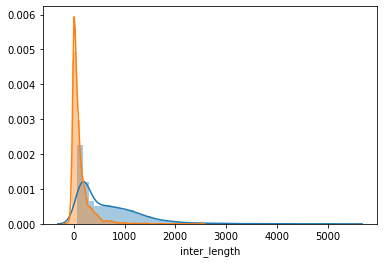

In [10]:
sns.distplot(ann_df.gene_length, label='genes')
sns.distplot(ann_df.inter_length, label='intergene')

In [11]:
import pysam

In [12]:
samfile = pysam.AlignmentFile("mit9313_SRR3334787.sorted.bam", "rb")

FileNotFoundError: [Errno 2] could not open alignment file `mit9313_SRR3334787.sorted.bam`: No such file or directory

In [13]:
samfile = pysam.AlignmentFile("SRR3334788.sorted.bam", "rb")

In [14]:
samfile.references

('BX548175.1',)

In [16]:
contig = 'BX548175.1'

In [14]:
def _read_calculate_overlap(read, 
                      gene_start, gene_end, 
                       gene_is_reversed):
    start = max(0, gene_start - 1)
    stop = gene_end 
    # utr_start / utr_stop
    utr_start = start
    utr_stop = stop
    if gene_is_reversed:
        utr_stop = utr_stop + 100
    else:
        utr_start = max(0, utr_start - 100)
    overlap = read.get_overlap(start, stop)
    read_overflow = (read.reference_end - read.reference_start) - overlap
    utr_overlap = read.get_overlap(utr_start, utr_stop)
    read_utr_overflow = (read.reference_end - read.reference_start) - utr_overlap
    
    return read_overflow, read_utr_overflow

    
def _read_add_to_dict(read_dict, read, 
                      gene_start, gene_end, 
                       gene_is_reversed):
    read_start = read.reference_start + 1
    read_end = read.reference_end 
    read_is_reverse = read.is_reverse
    read_mapping_quality  = read.mapping_quality
    read_overflow, read_utr_overflow = _read_calculate_overlap(read, gene_start, gene_end, gene_is_reversed)
    
    key = (read_start, read_end, read_is_reverse)
    read_dict.setdefault(key, [0, 0, 0, 0])
    read_dict[key][0] += read_mapping_quality
    read_dict[key][1] += 1
    read_dict[key][2] += read_overflow
    read_dict[key][3] += read_utr_overflow
    
def _read_decode_key_value(key, value):
    (read_start, read_end, read_is_reverse) = key
    (read_mapping_quality_sum, read_count, 
     read_overflow_sum, read_utr_overflow_sum) = value

    read_mapping_quality = read_mapping_quality_sum / read_count
    read_overflow = read_overflow_sum / read_count
    read_utr_overflow = read_utr_overflow_sum / read_count
    return (read_start, read_end, read_is_reverse, read_count, 
            read_mapping_quality, read_overflow, read_utr_overflow)

def _read_dict_item_to_record(key, value):
    (read_start, read_end, read_is_reverse, read_count, 
     read_mapping_quality, read_overflow, read_utr_overflow
    ) = _read_decode_key_value(key, value)

    return {
        'read_start' : read_start,
        'read_end' : read_end,
        'read_is_reverse' : read_is_reverse,
        'read_mapping_quality' : read_mapping_quality,
        'read_count' : read_count,
        'read_overflow' : read_overflow , 
        'read_utr_overflow' : read_utr_overflow,
    }

def _read_dict_item_to_count(key, value, gene_is_reversed, count_overflow):
    """ return tuple:
    number_of_reads, number_of_antisense_reads
    
    """
    (read_start, read_end, read_is_reverse, read_count, 
     read_mapping_quality, read_overflow, read_utr_overflow
    ) = _read_decode_key_value(key, value)

    if not count_overflow and read_overflow:
        return 0, 0
    if read_is_reverse == gene_is_reversed:
        return read_count, 0
    else:
        return 0, read_count



# TODO: UTR - 100 bases before gene start
# TODO: overlap for partial overlap genes

def _reads_to_dict(samfile, contig, 
                   gene_start, gene_end, 
                   gene_is_reversed):
    # pysam indexing is 0 based, annotation is 1 based
    start = max(0, gene_start - 1)
    stop = gene_end 
    
    if (stop is None) or (np.isnan(stop)):
        #last gene in the list
        return dict()
        
    if stop <= start:
        return dict()
    read_dict = dict()
    for read in samfile.fetch(contig=contig,start=start, stop=stop):
        # group reads by the start index
        _read_add_to_dict(read_dict, read, gene_start, gene_end, gene_is_reversed)
    return read_dict

        
def reads_per_gene(samfile, contig, 
                   gene_start, gene_end, 
                   gene_is_reversed):
    read_dict = _reads_to_dict(samfile, contig, 
                   gene_start, gene_end, 
                   gene_is_reversed)
    
    reads_list = [_read_dict_item_to_record(k,v) for k,v in read_dict.items()]
        
    return reads_list


def count_reads(samfile, contig, 
                   gene_start, gene_end, 
                   gene_is_reversed, count_overflow):
    read_dict = _reads_to_dict(samfile, contig, 
                   gene_start, gene_end, 
                   gene_is_reversed)

    count_list = [_read_dict_item_to_count(k,v, gene_is_reversed, count_overflow)
                  for k,v in read_dict.items()]
    if count_list == []:
        counts = [0,0]
    else:
        counts = list(map(sum, zip(*count_list)))
    return pd.Series({'reads': counts[0], 'as_reads': counts[1]})

In [139]:
ann_df.columns

Index(['contig_id', 'gene_id', 'feature_id', 'type', 'location', 'start',
       'stop', 'strand', 'function', 'aliases', 'figfam', 'evidence_codes',
       'nucleotide_sequence', 'aa_sequence', 'min_idx', 'max_idx',
       'inter_stop_idx', 'inter_length', 'gene_length', 'gene_is_reversed'],
      dtype='object')

In [15]:
def _read_dict_item_to_cover(cover_df, 
                             gene_start, gene_end, gene_is_reversed, 
                             key, value):
    
    (read_start, read_end, read_is_reverse, read_count, 
     read_mapping_quality, read_overflow, read_utr_overflow
    ) = _read_decode_key_value(key, value)
    if (gene_is_reversed  == read_is_reverse):
        column = 'reads'
    else:
        column = 'reads_as'

    start = max(read_start, gene_start)
    end = min(read_end, gene_end)
    cover_df.loc[range(start, end), column] = cover_df.loc[range(start, end), column] + read_count
        
        
        
def _select_gene_column(gene_type, gene_is_reversed, is_intergenic):
    
    if not gene_is_reversed: 
        gene_column = f'{gene_type}_sense'
    else:
        gene_column = f'{gene_type}_as'
    if is_intergenic:
        gene_column = 'gene_inter'
    return gene_column

def cover_reads(samfile, contig, 
                   gene_start, gene_end, 
                   gene_is_reversed, gene_type, is_intergenic):
    read_dict = _reads_to_dict(samfile, contig, 
                   gene_start, gene_end, 
                   gene_is_reversed)

    cover_df_columns = [
        'gene_inter', 
        'peg_sense', 'peg_as', 
        'rna_sense', 'rna_as', 
        'reads', 'reads_as'
    ]
    cover_df = pd.DataFrame(index=range(gene_start, gene_end), 
                            columns=cover_df_columns)
    
    cover_df.loc[:,'reads'] = 0
    cover_df.loc[:,'reads_as'] = 0
    # mark the gene location
    gene_column = _select_gene_column(gene_type, gene_is_reversed, is_intergenic)
    cover_df.loc[:,gene_column] = 1
    
    for k,v in read_dict.items():
        _read_dict_item_to_cover(cover_df, 
                             gene_start, gene_end, gene_is_reversed, 
                             k, v)
    
    return cover_df

In [25]:
samfile.get_reference_length(contig)

2410873

In [146]:
cover_df = cover_reads(samfile, 'BX548175.1', 174, 1340, False, 'peg', False)

In [147]:
cover_df.columns

Index(['gene_inter', 'peg_sense', 'peg_as', 'rna_sense', 'rna_as', 'reads',
       'reads_as'],
      dtype='object')

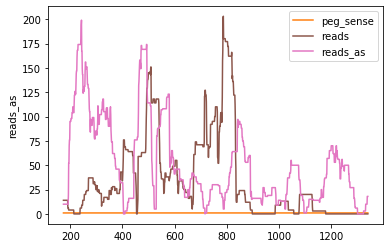

In [149]:

for c in cover_df.columns:
    sns.lineplot(x=cover_df.index, y=cover_df[c], label=c)

In [150]:
ann_df.columns

Index(['contig_id', 'gene_id', 'feature_id', 'type', 'location', 'start',
       'stop', 'strand', 'function', 'aliases', 'figfam', 'evidence_codes',
       'nucleotide_sequence', 'aa_sequence', 'min_idx', 'max_idx',
       'inter_stop_idx', 'inter_length', 'gene_length', 'gene_is_reversed'],
      dtype='object')

In [16]:
cover_func = lambda x: cover_reads(samfile, contig, 
                   x.iloc[0]['min_idx'], x.iloc[0]['max_idx'], 
                   x.iloc[0]['gene_is_reversed'],
                   x.iloc[0]['type'], is_intergenic=False)


group_cols = ['contig_id', 'gene_id', 'type']

cover_df = ann_df.groupby(group_cols).apply(cover_func)

In [17]:
cover_df.reset_index(inplace=True)

In [18]:
cover_df.rename(columns={'level_3': 'location'}, inplace=True)

In [23]:
for c in ['gene_inter', 'peg_sense', 'peg_as', 'rna_sense', 'rna_as', 'reads',
       'reads_as']:
    cover_df.loc[:,c] = pd.to_numeric(cover_df[c])

In [24]:
cover_df.shape

(2038600, 11)

In [25]:
cover_df.columns

Index(['contig_id', 'gene_id', 'type', 'location', 'gene_inter', 'peg_sense',
       'peg_as', 'rna_sense', 'rna_as', 'reads', 'reads_as'],
      dtype='object')

In [26]:
cover_df.head()

,contig_id,gene_id,type,location,gene_inter,peg_sense,peg_as,rna_sense,rna_as,reads,reads_as
0,MIT9313,PMIT9313_0001,peg,174,NaN,1.0,NaN,NaN,NaN,14,10
1,MIT9313,PMIT9313_0001,peg,175,NaN,1.0,NaN,NaN,NaN,14,10
2,MIT9313,PMIT9313_0001,peg,176,NaN,1.0,NaN,NaN,NaN,14,10
3,MIT9313,PMIT9313_0001,peg,177,NaN,1.0,NaN,NaN,NaN,14,10
4,MIT9313,PMIT9313_0001,peg,178,NaN,1.0,NaN,NaN,NaN,14,10


In [27]:
cover_df.dtypes

contig_id      object
gene_id        object
type           object
location        int64
gene_inter    float64
peg_sense     float64
peg_as        float64
rna_sense     float64
rna_as        float64
reads           int64
reads_as        int64
dtype: object

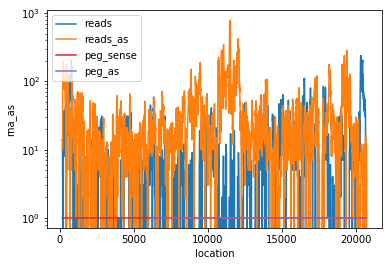

In [36]:
df = cover_df.head(20000)
for c in ['reads',
       'reads_as', 'gene_inter', 'peg_sense',
          'peg_as', 'rna_sense', 'rna_as', ]:
    sns.lineplot(x=df['location'], y=df[c], label=c)
plt.yscale('log')

In [153]:
cover_df.shape

(3044,)

In [63]:

count_func = lambda x: count_reads(samfile, contig, 
        x['min_idx'], x['max_idx'], x['gene_is_reversed'], count_overflow=True)



count_df = ann_df.apply(count_func, axis=1)

In [124]:

inter_count_func = lambda x: count_reads(samfile, contig, 
         x['max_idx'], x['inter_stop_idx'], 
         gene_is_reversed=False, count_overflow=False)



inter_count_df = ann_df.apply(inter_count_func, axis=1)

In [51]:
ann_df.columns

Index(['contig_id', 'gene_id', 'feature_id', 'type', 'location', 'start',
       'stop', 'strand', 'function', 'aliases', 'figfam', 'evidence_codes',
       'nucleotide_sequence', 'aa_sequence', 'min_idx', 'max_idx',
       'inter_stop_idx', 'inter_length', 'gene_length', 'gene_is_reversed'],
      dtype='object')

In [112]:
ann_df.iloc[3043]

contig_id                                                        MIT9313
gene_id                                                    PMIT9313_2997
feature_id                                          fig|1218.91.peg.2997
type                                                                 peg
location                                         MIT9313_2409531_2410637
start                                                            2409531
stop                                                             2410637
strand                                                                 +
function                                 Threonine synthase (EC 4.2.3.1)
aliases                                                              NaN
figfam                                                       FIG00000134
evidence_codes                 isu;Threonine_and_Homoserine_Biosynthesis
nucleotide_sequence    gtgtccctcagccaaaacctccctcaagctatctccacaacgcctg...
aa_sequence            MSLSQNLPQAISTTPVMQDWPGLIEAYR

In [113]:
count_reads(samfile, 'BX548175.1', 2410637, np.NaN, False, False)

reads       0
as_reads    0
dtype: int64

In [105]:
ann_df.iloc[14:16]

,contig_id,gene_id,feature_id,type,location,start,stop,strand,function,aliases,figfam,evidence_codes,nucleotide_sequence,aa_sequence,min_idx,max_idx,inter_stop_idx,inter_length,gene_length,gene_is_reversed
14,MIT9313,PMIT9313_0015,fig|1218.91.peg.15,peg,MIT9313_18861_17842,18861,17842,-,tRNA dihydrouridine synthase A,NaN,FIG00940761,ff,atgcagcatgaatcaatgattgctcctttcacgccacaggttgatg...,MQHESMIAPFTPQVDGAYRFSVAPMLDCTDRHFRVLMRQISRRALL...,17842,18861,18843.0,-18.0,1019,True
15,MIT9313,PMIT9313_0016,fig|1218.91.peg.16,peg,MIT9313_18965_18843,18965,18843,-,hypothetical protein,NaN,NaN,NaN,gtggctatcagcagagaacgacgactcaatagcaaagcagtaatgg...,MAISRERRLNSKAVMGISAAKINDLLSRKAQNNYECSMNQ,18843,18965,18916.0,-49.0,122,True


In [52]:
samfile.mapped

10789221

In [125]:
inter_count_df.describe()

,reads,as_reads
count,3044.000000,3044.000000
mean,195.972733,124.082786
std,5145.448819,1587.858099
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,10.000000,18.000000
max,274602.000000,67929.000000


In [126]:
count_df.describe()

,reads,as_reads
count,3044.000000,3044.000000
mean,291.438568,3028.392904
std,1914.107676,26061.696375
min,0.000000,0.000000
25%,24.000000,62.000000
50%,79.000000,403.000000
75%,226.000000,1262.250000
max,93064.000000,669673.000000


In [127]:
df = ann_df.join(count_df)

In [128]:
df = df.join(inter_count_df, rsuffix='_inter')

In [129]:
df.columns

Index(['contig_id', 'gene_id', 'feature_id', 'type', 'location', 'start',
       'stop', 'strand', 'function', 'aliases', 'figfam', 'evidence_codes',
       'nucleotide_sequence', 'aa_sequence', 'min_idx', 'max_idx',
       'inter_stop_idx', 'inter_length', 'gene_length', 'gene_is_reversed',
       'reads', 'as_reads', 'reads_inter', 'as_reads_inter'],
      dtype='object')

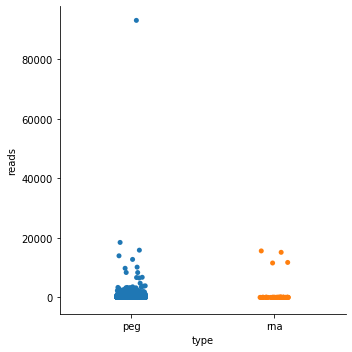

In [130]:
sns.catplot(data=df, x='type', y='reads')

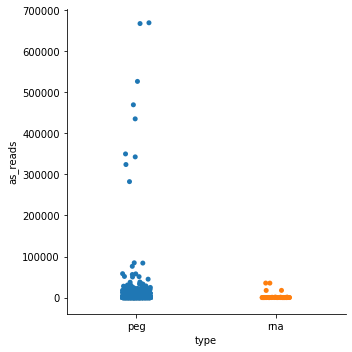

In [131]:
sns.catplot(data=df, x='type', y='as_reads')

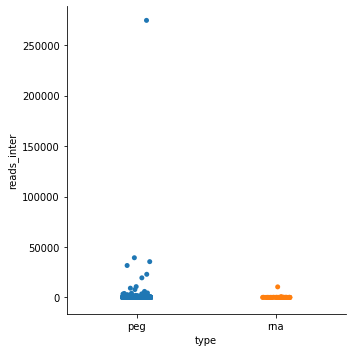

In [132]:
sns.catplot(data=df, x='type', y='reads_inter')

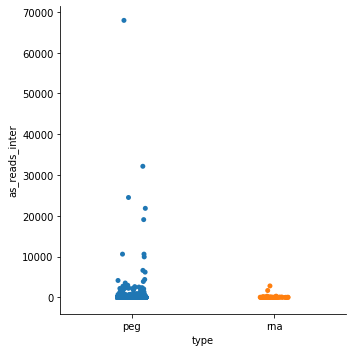

In [133]:
sns.catplot(data=df, x='type', y='as_reads_inter')

In [134]:
df.columns

Index(['contig_id', 'gene_id', 'feature_id', 'type', 'location', 'start',
       'stop', 'strand', 'function', 'aliases', 'figfam', 'evidence_codes',
       'nucleotide_sequence', 'aa_sequence', 'min_idx', 'max_idx',
       'inter_stop_idx', 'inter_length', 'gene_length', 'gene_is_reversed',
       'reads', 'as_reads', 'reads_inter', 'as_reads_inter'],
      dtype='object')

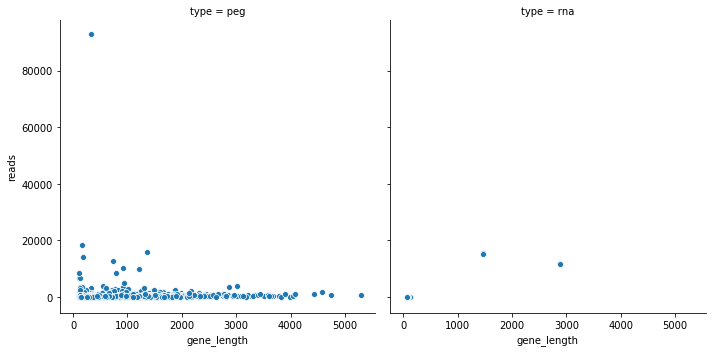

In [135]:
sns.relplot(data=df, x='gene_length', y='reads', col='type')

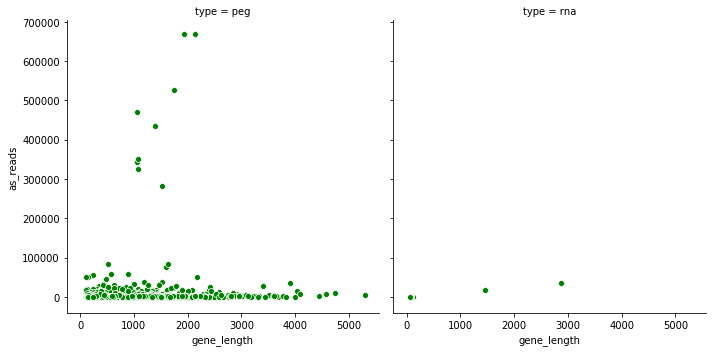

In [137]:
sns.relplot(data=df, x='gene_length', y='as_reads', col='type', color='green')

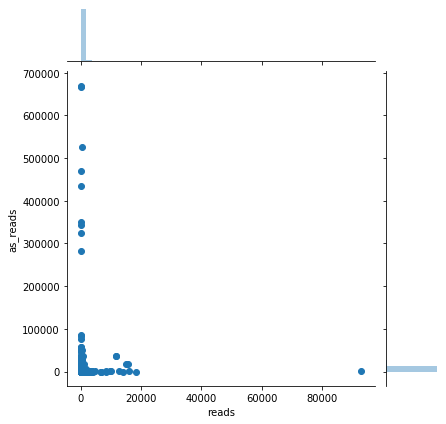

In [90]:
sns.jointplot(data=df, x='reads', y='as_reads')

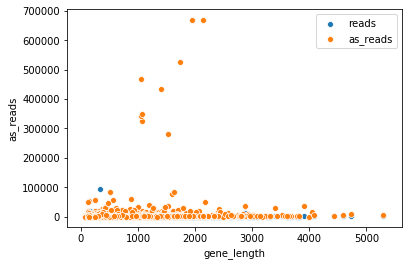

In [85]:
sns.scatterplot(x=df.gene_length, y=df.reads, label='reads')
sns.scatterplot(x=df.gene_length, y=df.as_reads, label='as_reads')


In [98]:
df.loc[df.function.str.contains('hypothetical')]['function'].unique()

array(['FIG00940173: hypothetical protein', 'hypothetical protein',
       'FIG00943446: hypothetical protein',
       'FIG00940904: hypothetical protein',
       'FIG00940521: hypothetical protein',
       'FIG00941180: hypothetical protein',
       'FIG00940146: hypothetical protein',
       'FIG00940935: hypothetical protein',
       'FIG00940211: hypothetical protein',
       'FIG00943401: hypothetical protein',
       'FIG00940093: hypothetical protein',
       'FIG00941294: hypothetical protein',
       'FIG00940295: hypothetical protein',
       'FIG00944018: hypothetical protein',
       'FIG00941409: hypothetical protein',
       'FIG00942306: hypothetical protein',
       'FIG00940560: hypothetical protein',
       'FIG00941763: hypothetical protein',
       'FIG00942020: hypothetical protein',
       'FIG00941793: hypothetical protein',
       'FIG00941923: hypothetical protein',
       'FIG00944625: hypothetical protein',
       'FIG00941770: hypothetical protein',
       '

In [96]:
(df.function == 'hypothetical protein').sum()

704

In [138]:
df.nlargest(columns='reads', n=5)

,contig_id,gene_id,feature_id,type,location,start,stop,strand,function,aliases,...,min_idx,max_idx,inter_stop_idx,inter_length,gene_length,gene_is_reversed,reads,as_reads,reads_inter,as_reads_inter
2632,MIT9313,PMIT9313_2589,fig|1218.91.peg.2589,peg,MIT9313_2059734_2059408,2059734,2059408,-,FIG00943694: hypothetical protein,NaN,...,2059408,2059734,2059893.0,159.0,326,True,93064,164,18,67929
1620,MIT9313,PMIT9313_1600,fig|1218.91.peg.1600,peg,MIT9313_1272346_1272188,1272346,1272188,-,FIG00944368: hypothetical protein,NaN,...,1272188,1272346,1272413.0,67.0,158,True,18475,6,0,194
973,MIT9313,PMIT9313_0958,fig|1218.91.peg.958,peg,MIT9313_832281_833648,832281,833648,+,Chloride channel protein-related protein,NaN,...,832281,833648,833843.0,195.0,1367,False,15878,845,208,0
211,MIT9313,NaN,fig|1218.91.rna.3,rna,MIT9313_208864_210328,208864,210328,+,Small Subunit Ribosomal RNA; ssuRNA; SSU rRNA,NaN,...,208864,210328,210511.0,183.0,1464,False,15620,17508,5,297
2252,MIT9313,NaN,fig|1218.91.rna.36,rna,MIT9313_1753624_1752160,1753624,1752160,-,Small Subunit Ribosomal RNA; ssuRNA; SSU rRNA,NaN,...,1752160,1753624,1753866.0,242.0,1464,True,15156,17369,10461,11
